## Data Cleaning

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import seaborn as sns
from scipy.stats import mode
from functools import reduce
# from pykalman import KalmanFilter
import pmdarima as pm

In [35]:
DGS1 = pd.read_excel("DATA/DGS1.xls", skiprows=10)
DGS2 = pd.read_excel("DATA/DGS2.xls", skiprows=10)
DGS3MO   = pd.read_excel("DATA/DGS3MO.xls", skiprows=10)
DGS6MO  = pd.read_excel("DATA/DGS6MO.xls", skiprows=10)
DGS10= pd.read_excel("DATA/DGS10.xls", skiprows=10)
DGS3 = pd.read_excel("DATA/DGS3.xls", skiprows=10)
DGS5= pd.read_excel("DATA/DGS5.xls", skiprows=10)
DGS7= pd.read_excel("DATA/DGS7.xls", skiprows=10)


#Drop the 0 columns
DGS1 = DGS1[(DGS1 != 0.00).all(axis=1)]
DGS2 = DGS2[(DGS2 != 0.00).all(axis=1)]
DGS3MO = DGS3MO[(DGS3MO != 0.00).all(axis=1)]
DGS6MO = DGS6MO[(DGS6MO != 0.00).all(axis=1)]
DGS10 = DGS10[(DGS10 != 0.00).all(axis=1)]
DGS3 = DGS3[(DGS3 != 0.00).all(axis=1)]
DGS5 = DGS5[(DGS5 != 0.00).all(axis=1)]
DGS7 = DGS7[(DGS7 != 0.00).all(axis=1)]


In [36]:
index_comparison = {
    'DGS2': set(DGS1.index) == set(DGS2.index),
    'DGS3MO': set(DGS1.index) == set(DGS3MO.index),
    'DGS6MO': set(DGS1.index) == set(DGS6MO.index),
    'DGS10': set(DGS1.index) == set(DGS10.index),
    'DGS3': set(DGS1.index) == set(DGS3.index),
    'DGS5': set(DGS1.index) == set(DGS5.index),
    'DGS7': set(DGS1.index) == set(DGS7.index),
}

for df_name, comparison_result in index_comparison.items():
    print(f"{df_name} has the same indices as DGS1: {comparison_result}")

DGS2 has the same indices as DGS1: True
DGS3MO has the same indices as DGS1: False
DGS6MO has the same indices as DGS1: True
DGS10 has the same indices as DGS1: True
DGS3 has the same indices as DGS1: True
DGS5 has the same indices as DGS1: True
DGS7 has the same indices as DGS1: True


In [37]:
# Assume df1, df2, df3, ... are DataFrame objects you want to merge
dataframes = [DGS3MO, DGS6MO, DGS1, DGS2,DGS3, DGS5, DGS7,DGS10]

# Using reduce to merge multiple DataFrames on a common key
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date'), dataframes)

In [38]:
merged_df

,observation_date,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10
0,2014-01-02,0.07,0.09,0.13,0.39,0.76,1.72,2.41,3.00
1,2014-01-03,0.07,0.10,0.13,0.41,0.80,1.73,2.42,3.01
2,2014-01-06,0.05,0.08,0.12,0.40,0.78,1.70,2.38,2.98
3,2014-01-07,0.04,0.08,0.13,0.40,0.80,1.69,2.37,2.96
4,2014-01-08,0.05,0.08,0.13,0.43,0.87,1.77,2.44,3.01
...,...,...,...,...,...,...,...,...,...
2517,2024-02-13,5.45,5.32,4.99,4.64,4.44,4.31,4.33,4.31
2518,2024-02-14,5.43,5.31,4.94,4.56,4.38,4.25,4.27,4.27
2519,2024-02-15,5.43,5.30,4.93,4.56,4.36,4.22,4.25,4.24
2520,2024-02-16,5.44,5.31,4.98,4.64,4.43,4.29,4.31,4.30


## The model

The interest fitting framework 
$$y(s)=\beta_0+\beta_1 e^{-\lambda s}+\beta_2 \lambda s e^{-\lambda s}$$
The zero coupon rate $Y(T)$ for maturity T corresponding to the instantaneous forward rate $y(s)$ is given by
$$Y(T)=\frac{1}{T} \int_0^T y(s) d s$$
Take integrals for both sides from 1 to $T$, we get
$$Y(T)=\beta_0+\beta_1 \frac{1-e^{-\lambda T}}{\lambda T}+\beta_2\left(\frac{1-e^{-\lambda T}}{\lambda T}-e^{-\lambda T}\right)$$

## Fit the model

### Lambda not fixed

In [29]:
# Define the model function
def model(T, beta0, beta1, beta2, lambda_):
    return beta0 + beta1 * (1 - np.exp(-lambda_ * T)) / (lambda_ * T) + \
           beta2 * ((1 - np.exp(-lambda_ * T)) / (lambda_ * T) - np.exp(-lambda_ * T))

# Initial guesses for parameters
initial_guess = np.array([0.03, 0.01, 0.01, 0.5])

T = np.array([0.25,0.5,1,2, 3, 5, 7, 10])
beta0=[]
beta1=[]
beta2=[]
lmda=[]
mse_err=[]
bounds = ([-np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, 100]) 
for row in range(len(merged_df)):
    Y = np.array(merged_df.iloc[row][1:].values)
    # Ensure T and Y are numpy arrays of numeric type
    T = np.asarray(T, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # Ensure initial guesses are of numeric type
    initial_guess = np.asarray(initial_guess, dtype=float)
    # Perform the optimization
    popt, pocv = curve_fit(model, T, Y, p0=initial_guess, maxfev=10000, bounds=bounds)
    
    # Use the optimized parameters to calculate the fitted curve
    fitted_Y = model(T, *popt)

    # Calculate the calibration error (sum of squared differences)
    calibration_error = np.mean((Y-fitted_Y) ** 2)

    # Extract the optimized parameters
    beta0_opt, beta1_opt, beta2_opt, lambda_opt = popt
    beta0.append(beta0_opt)
    beta1.append(beta1_opt)
    beta2.append(beta2_opt)
    lmda.append(lambda_opt)
    mse_err.append(calibration_error)



MSE Error

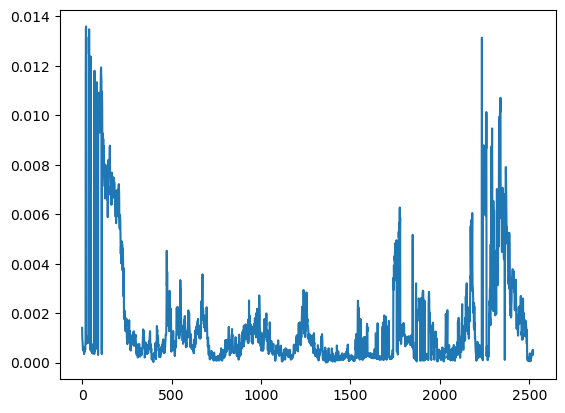

In [30]:
plt.plot(mse_err)

Plot of Lambda

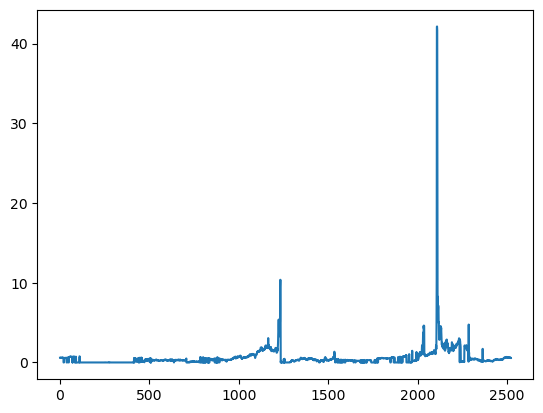

In [31]:
plt.plot(lmda)

Result: Lambda sometimes explodes to a large value. If we do not limit lambda to [0,100], it will go even larger. Actually, a large lambda will lead to colinearity in this model. When lambda is very large, the two terms will be close to each other since $e^{-\lambda T}$ is small.

### Lambda Fixed

Choose a fixed lambda by finding the largest R^2 in total. (Because of scaling, we don't use MSE)
Since lambda is fixed, we simply use linear regression to fit the model.

In [43]:
T = np.array([0.25,0.5,1, 2, 3, 5, 7, 10], dtype=float)
max_total_rsq = 0
lambda_chosen = 0

# Fixed lambda value
for lambda_fixed in [0.01*x for x in range(1,101)]:
    total_rsq = 0
    for row in range(len(merged_df)):
        Y = np.array(merged_df.iloc[row][1:].values, dtype=float)

        # Transform the features based on the fixed lambda
        X1 = (1 - np.exp(-lambda_fixed * T)) / (lambda_fixed * T)
        X2 = X1 - np.exp(-lambda_fixed * T)

        # Stack the features horizontally to create a feature matrix
        X = np.vstack((np.ones_like(T), X1, X2)).T

        # Create a linear regression object
        reg = LinearRegression()

        # Fit the regression model to the data
        reg.fit(X, Y)

        # Predicted values
        Y_pred = reg.predict(X)

        # Calculate the Mean Squared Error (MSE)
        # mse0 = np.mean((Y - Y_pred) ** 2)
        rsq = reg.score(X, Y)
        total_rsq += rsq
    if total_rsq > max_total_rsq:
        max_total_rsq = total_rsq
        lambda_chosen = lambda_fixed
        
print("Lambda chosen:",lambda_chosen)

Lambda chosen: 0.47000000000000003


Fit the model with chosen lambda. Plot the fitting result of a certain row. (This is an underfit)

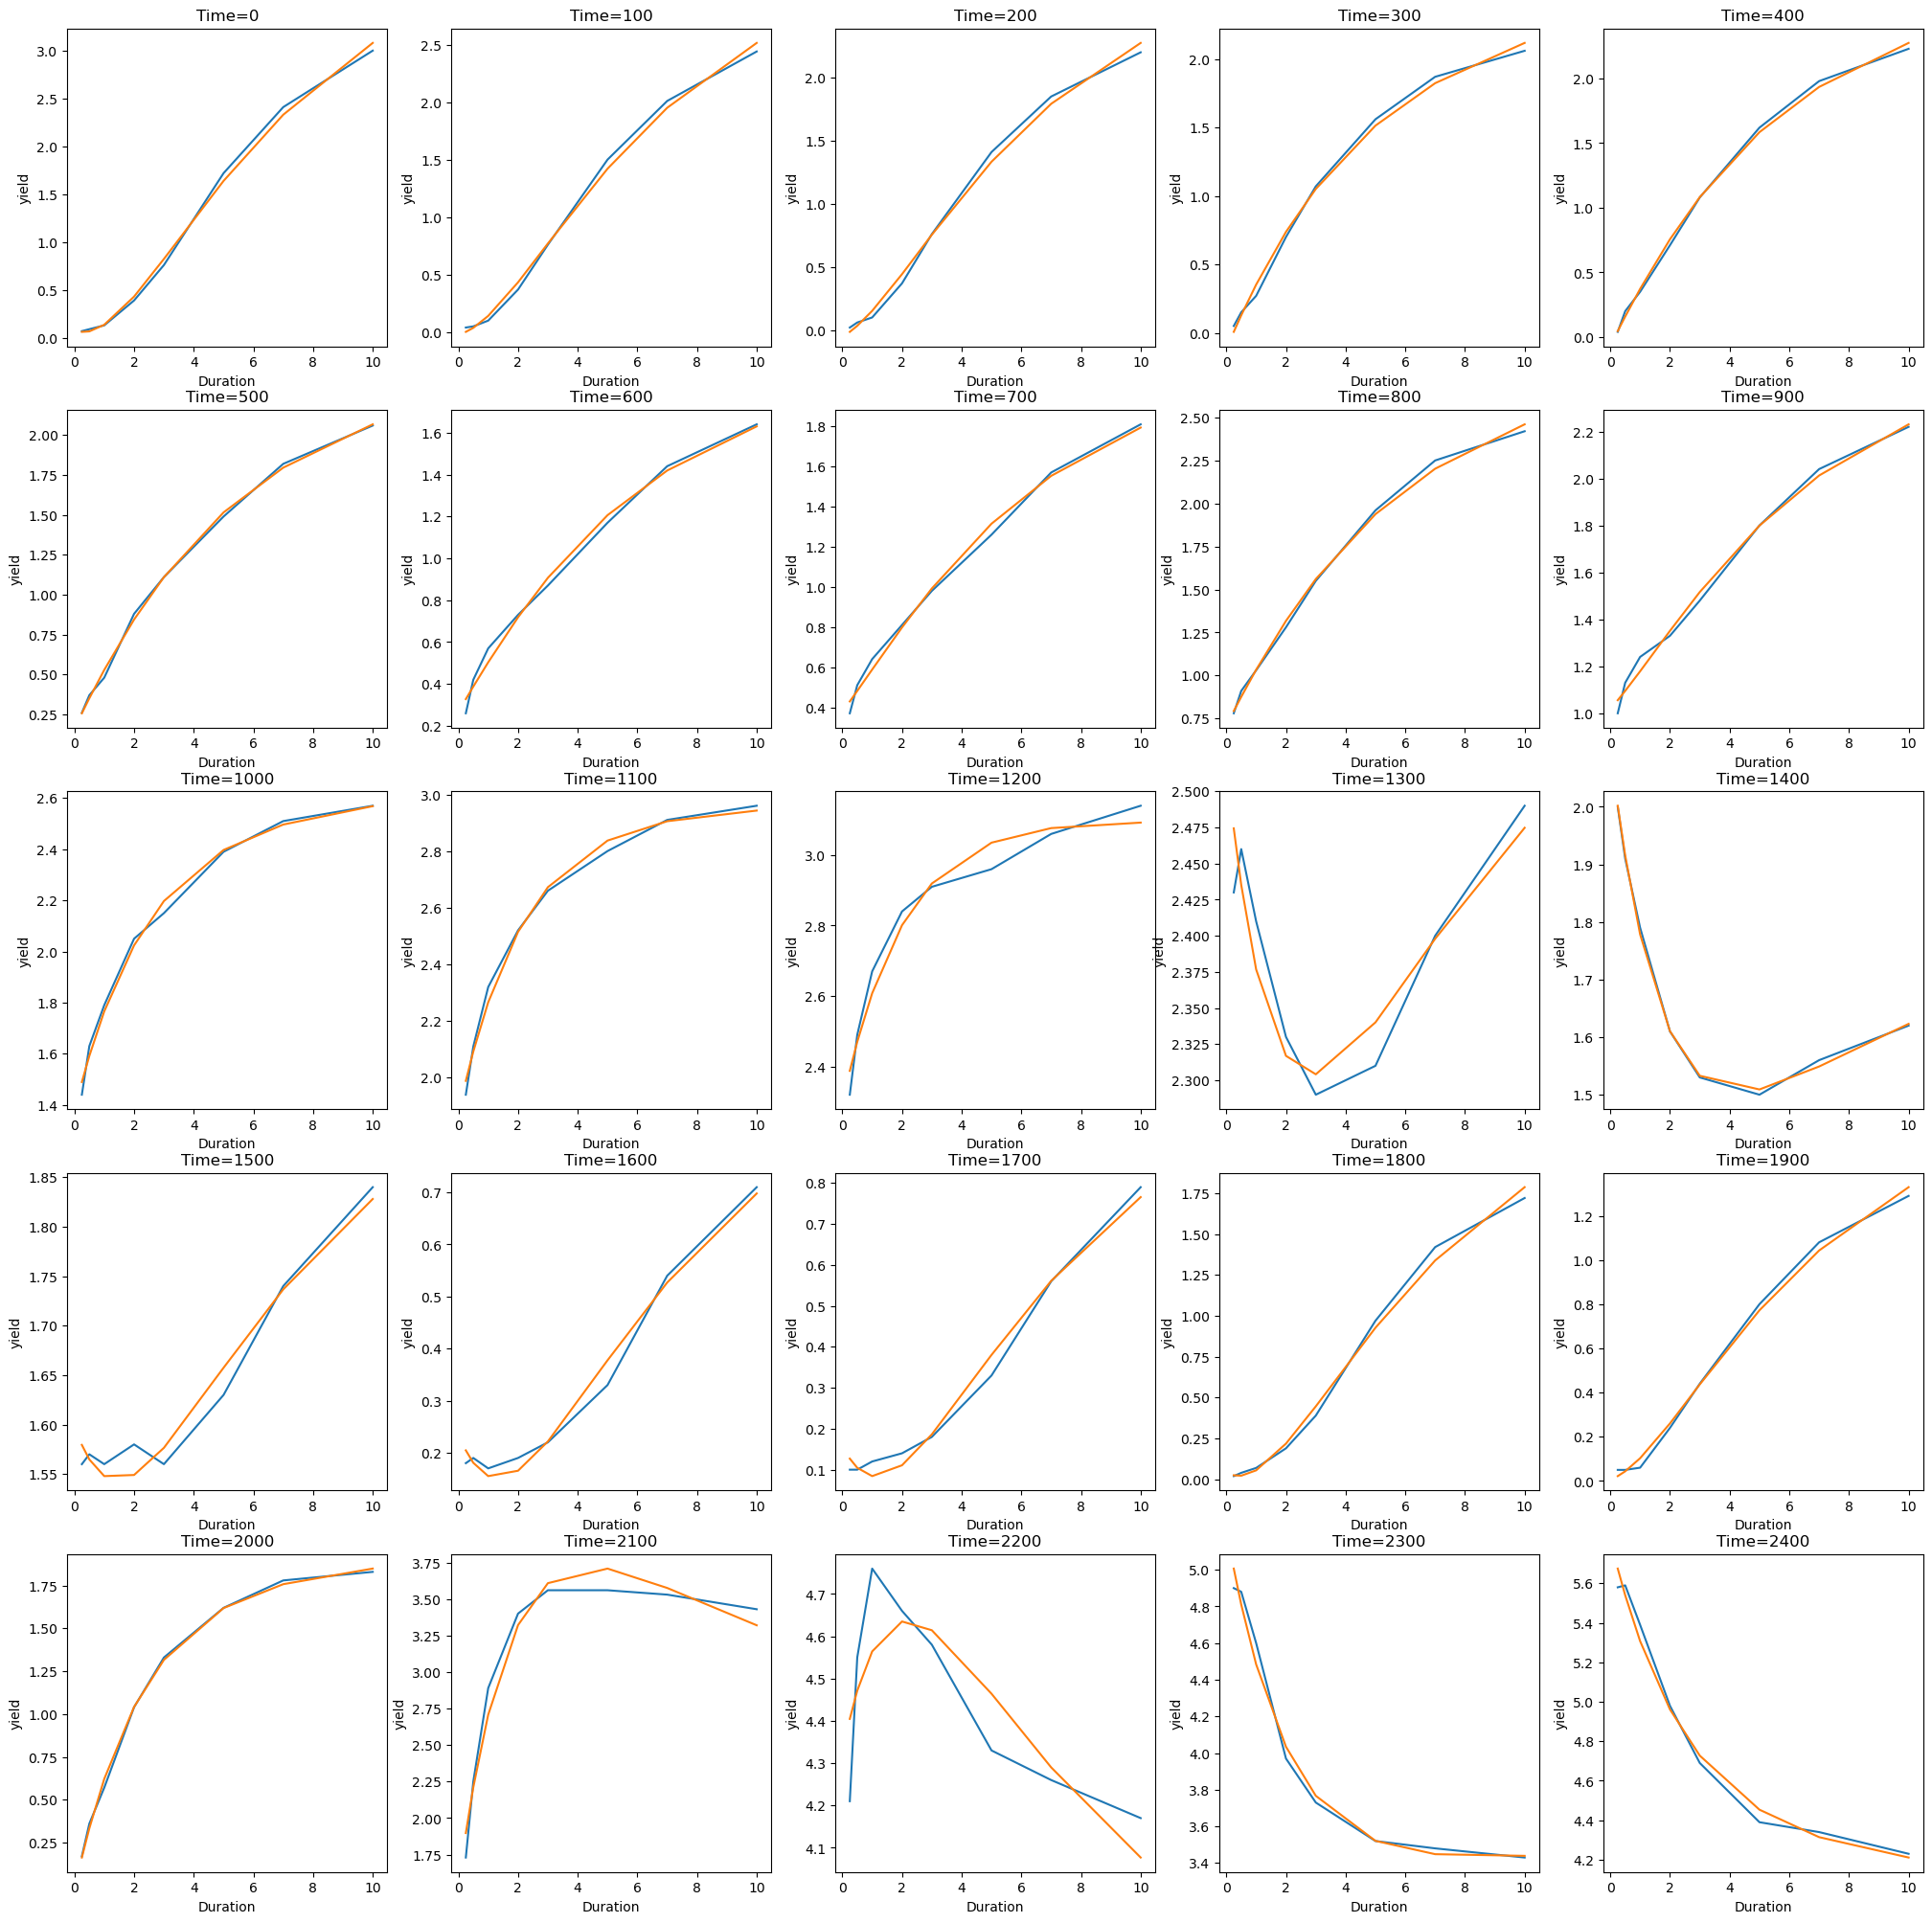

In [51]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fixed lambda value
lambda_fixed = 0.47  # Replace with the actual fixed value of lambda

# Setting up the figure and subplots
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
i=0
j=0

# Sample data for T and Y
# NOTE: Replace these arrays with your actual data.
T = np.array([0.25,0.5,1,2, 3, 5, 7, 10], dtype=float)

beta0=[]
beta1=[]
beta2=[]
mse = []
R_squared=[]

for row in range(len(merged_df)):
    #if row > 2000:
        #lambda_fixed = 20
    Y = np.array(merged_df.iloc[row][1:].values, dtype=float)

    # Transform the features based on the fixed lambda
    X1 = (1 - np.exp(-lambda_fixed * T)) / (lambda_fixed * T)
    X2 = X1 - np.exp(-lambda_fixed * T)

    # Stack the features horizontally to create a feature matrix
    X = np.vstack((np.ones_like(T), X1, X2)).T

    # Create a linear regression object
    reg = LinearRegression()

    # Fit the regression model to the data
    reg.fit(X, Y)

    # Predicted values
    Y_pred = reg.predict(X)
    Rsq = reg.score(X, Y)

    # Calculate the Mean Squared Error (MSE)
    mse0 = np.mean((Y - Y_pred) ** 2)
    mse.append(mse0)
    beta0.append(reg.intercept_)
    beta1.append(reg.coef_[1])
    beta2.append(reg.coef_[2])
    R_squared.append(Rsq)
    # Plot something
    if row%100 == 0:
        if i == 5:
            continue
        axs[i,j].plot(T, Y, label="Actual")
        axs[i,j].plot(T, Y_pred, label="Prediction")
        axs[i,j].set_xlabel('Duration')
        axs[i,j].set_ylabel('yield')
        axs[i,j].set_title(f'Time={row}')
        j += 1
        if j == 5:
            i += 1
            j = 0
        
        
R_squared_old = R_squared

Plot the time series, MSE and R squared

Text(0.5, 1.0, 'R Squared')

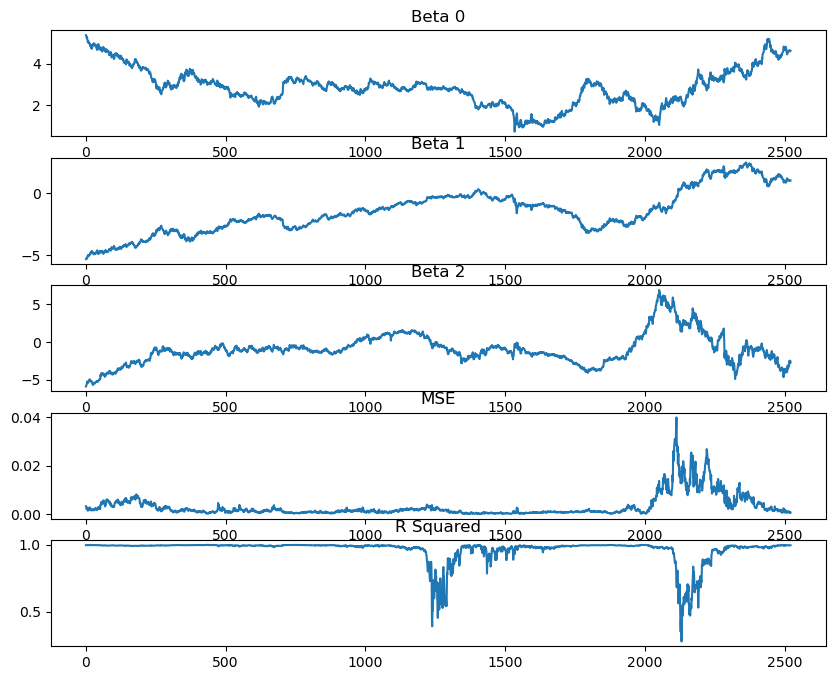

In [49]:
fig, axs = plt.subplots(5, 1, figsize=(10, 8))
axs[0].plot(beta0)
axs[0].set_title("Beta 0")
axs[1].plot(beta1)
axs[1].set_title("Beta 1")
axs[2].plot(beta2)
axs[2].set_title("Beta 2")
#axs[3].plot(lmda)
#axs[3].set_title("Lambda")
axs[3].plot(mse)
axs[3].set_title("MSE")
axs[4].plot(R_squared)
axs[4].set_title("R Squared")

Result: Beta are mostly stable. (I will put the test tomorrow) However, the fitting result will be very bad when there is an inverted yield curve. See the plot below, when DGS1 goes above DGS3, $R^2$ decreases

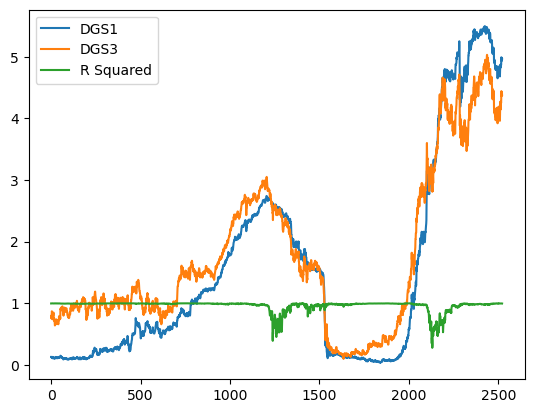

In [52]:
plt.plot(merged_df['DGS1'], label='DGS1')
#plt.plot(merged_df['DGS2'])
plt.plot(merged_df['DGS3'], label='DGS3')
#plt.plot(merged_df['DGS5'])
#plt.plot(merged_df['DGS7'])
#plt.plot(merged_df['DGS10'])
#plt.plot(merged_df['DGS3MO'])
#plt.plot(merged_df['DGS6MO'])
plt.plot(R_squared,label='R Squared')
plt.legend()

## Improvement: Svensson model

$$Y(T)=\beta_0+\beta_1 \frac{1-e^{-\lambda_1 T}}{\lambda_1 T}+\beta_2\left(\frac{1-e^{-\lambda_1 T}}{\lambda_1 T}-e^{-\lambda_1 T}\right)+\beta_3\left(\frac{1-e^{-\lambda_2 T}}{\lambda_2 T}-e^{-\lambda_2 T}\right)$$
Add one more lambda term to add some degrees of freedom. Typically, $\lambda_2$ are chosen to be large to fit the distinct shape of yield curves

0.8487862961188558


Text(0.5, 1.0, 'R Squared')

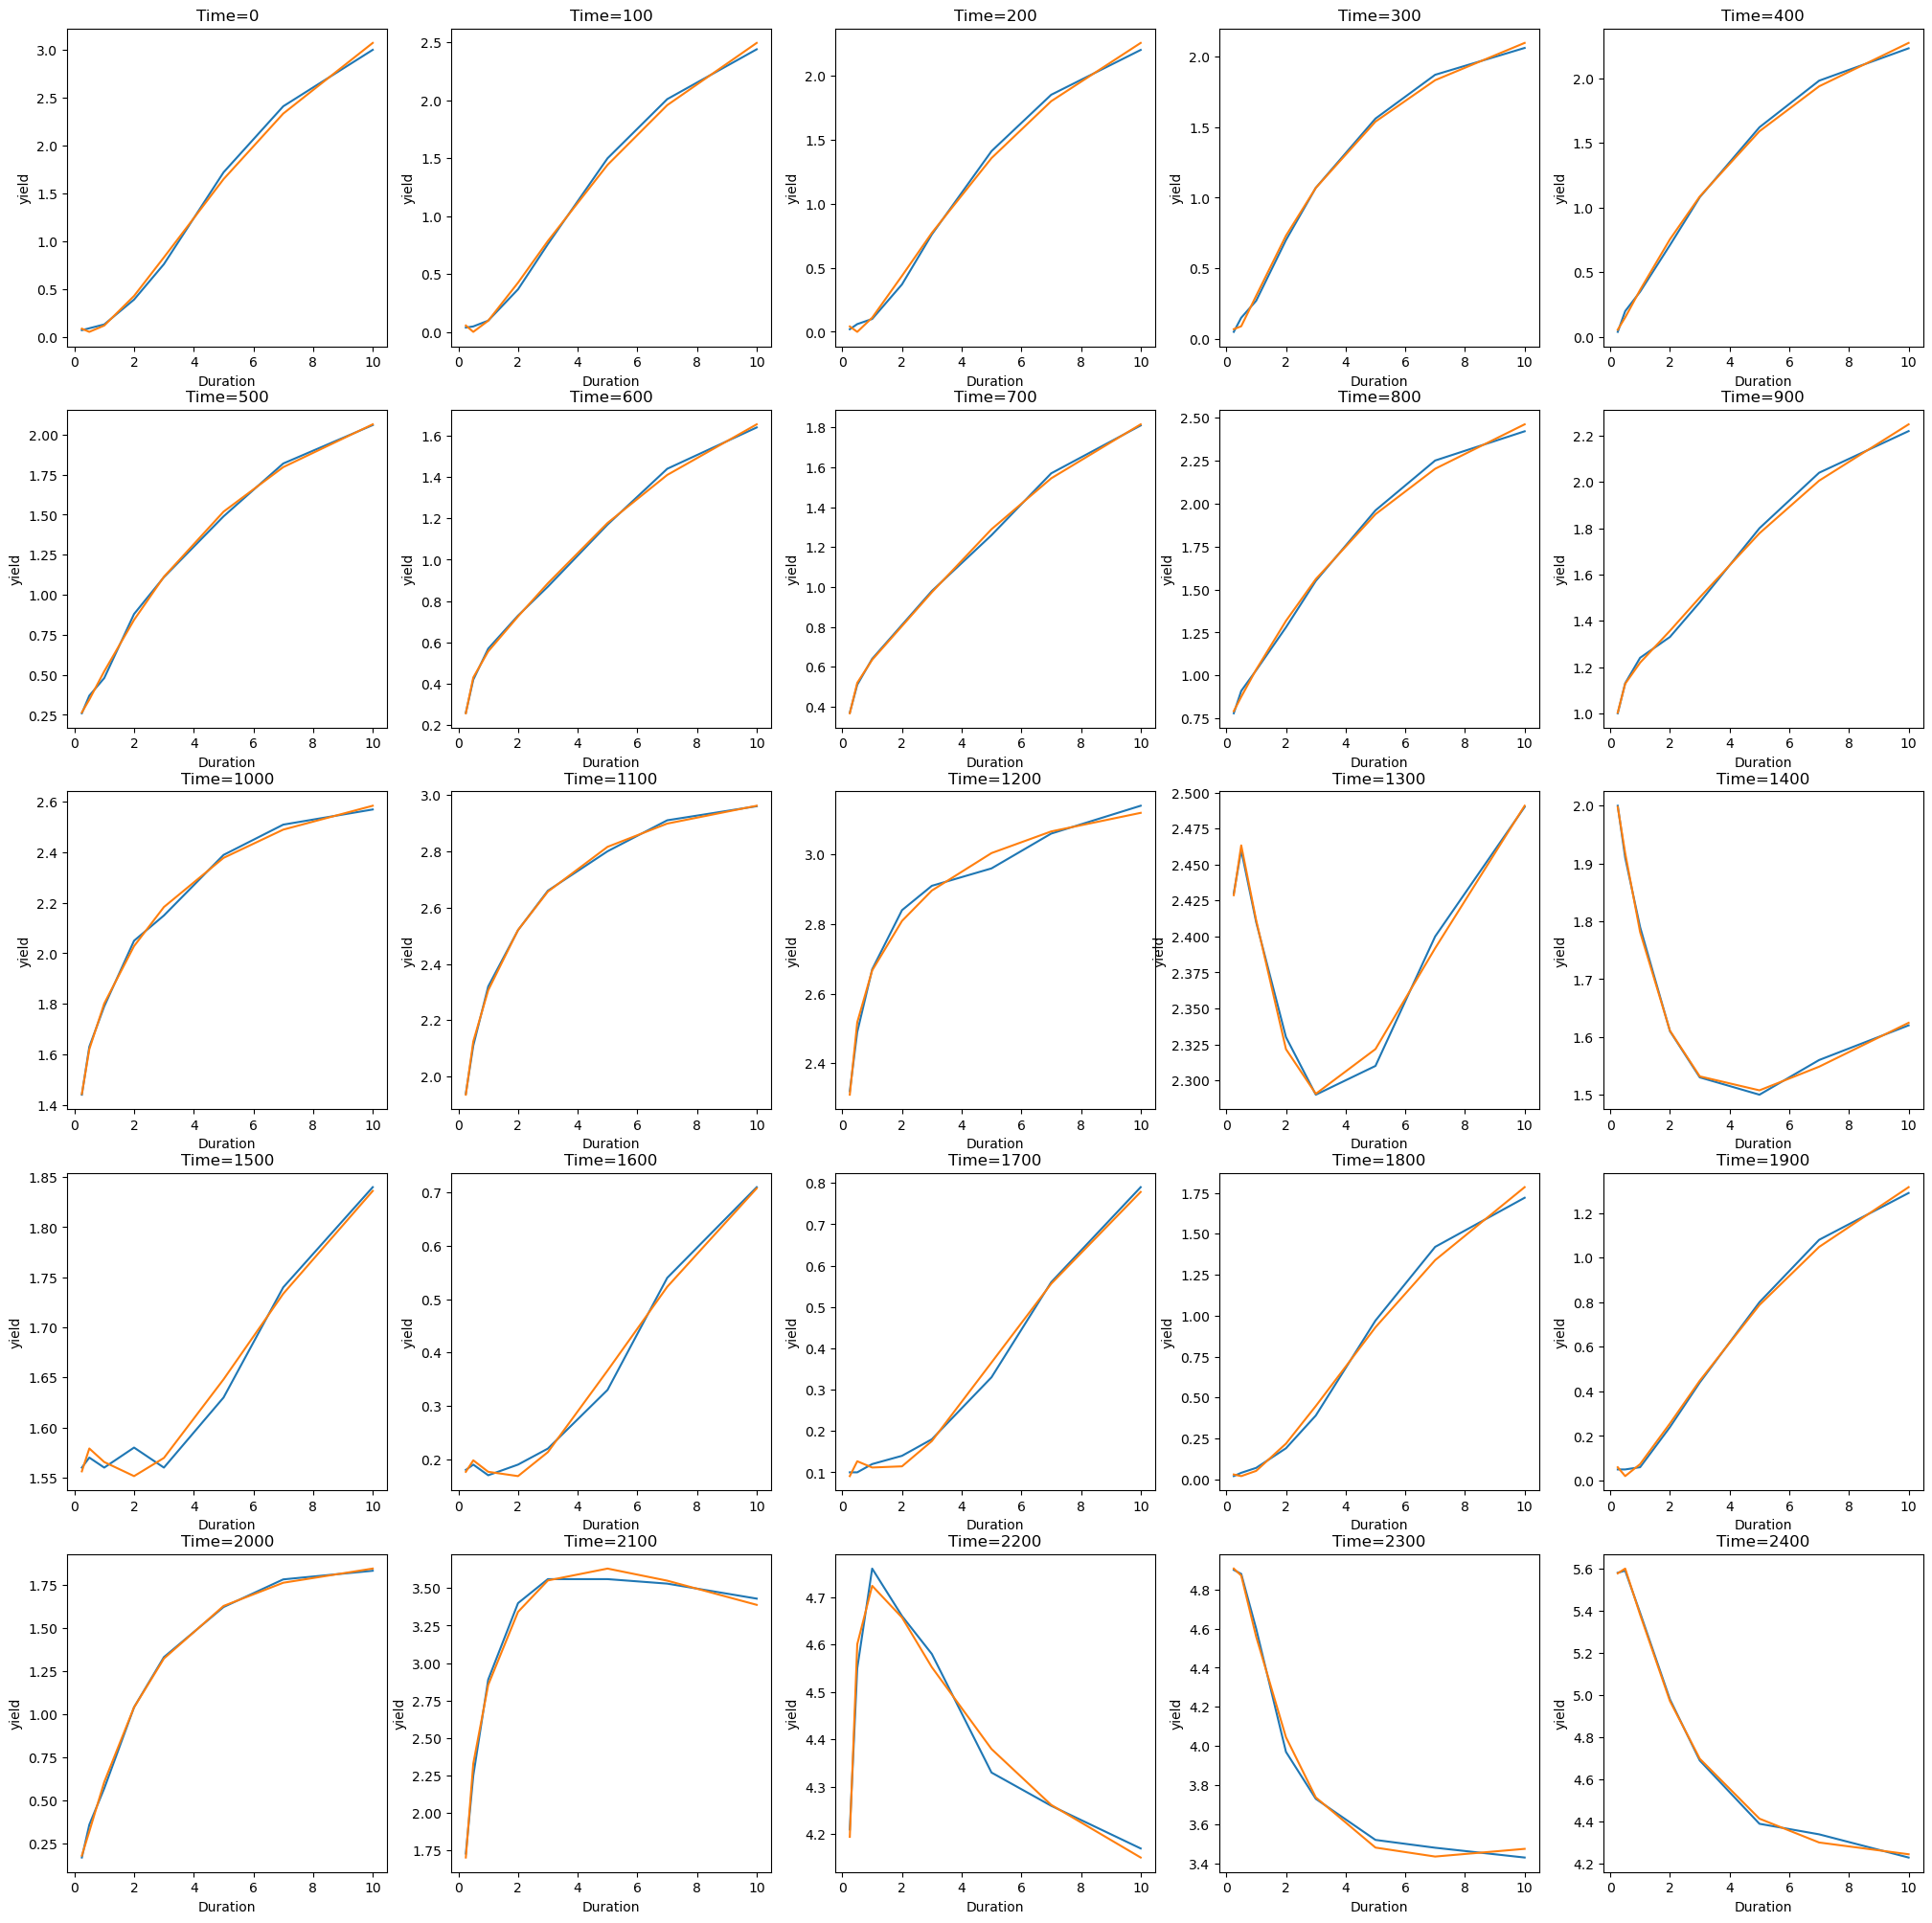

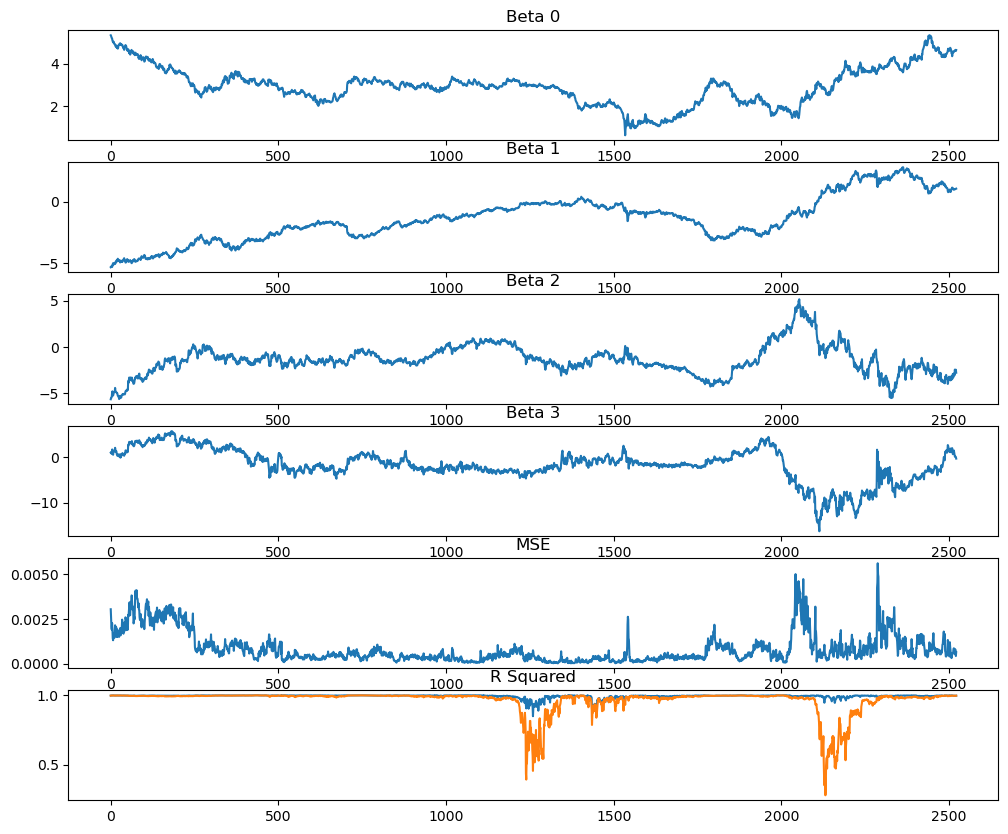

In [54]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Fixed lambda values
lambda_fixed_1 = 0.47  # This is your existing lambda value
lambda_fixed_2 = 40  # Additional lambda value for the Svensson model; adjust as necessary

# Sample data for T and Y
# Replace these arrays with your actual data
T = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10], dtype=float)

# Setting up the figure and subplots
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
i=0
j=0

beta0 = []
beta1 = []
beta2 = []
beta3 = []  # Additional coefficient for the Svensson model
mse = []
R_squared = []

for row in range(len(merged_df)):
    Y = np.array(merged_df.iloc[row][1:].values, dtype=float)

    # Transform the features based on the fixed lambda values
    X1 = (1 - np.exp(-lambda_fixed_1 * T)) / (lambda_fixed_1 * T)
    X2 = X1 - np.exp(-lambda_fixed_1 * T)
    X3 = ((1 - np.exp(-lambda_fixed_2 * T)) / (lambda_fixed_2 * T)) - np.exp(-lambda_fixed_2 * T)  # Additional term for Svensson

    # Stack the features horizontally to create a feature matrix
    X = np.vstack((np.ones_like(T), X1, X2, X3)).T  # Now includes X3

    # Create a linear regression object
    reg = LinearRegression()

    # Fit the regression model to the data
    reg.fit(X, Y)

    # Predicted values
    Y_pred = reg.predict(X)
    Rsq = reg.score(X, Y)

    # Calculate the Mean Squared Error (MSE)
    mse0 = np.mean((Y - Y_pred) ** 2)
    mse.append(mse0)
    beta0.append(reg.intercept_)
    beta1.append(reg.coef_[1])
    beta2.append(reg.coef_[2])
    beta3.append(reg.coef_[3])  # Store the coefficient for the additional term
    R_squared.append(Rsq)
    
    # Plot something
    if row%100 == 0:
        if i == 5:
            continue
        axs[i,j].plot(T, Y, label="Actual")
        axs[i,j].plot(T, Y_pred, label="Prediction")
        axs[i,j].set_xlabel('Duration')
        axs[i,j].set_ylabel('yield')
        axs[i,j].set_title(f'Time={row}')
        j += 1
        if j == 5:
            i += 1
            j = 0

print(np.min(R_squared))

fig, axs = plt.subplots(6, 1, figsize=(12, 10))
axs[0].plot(beta0)
axs[0].set_title("Beta 0")
axs[1].plot(beta1)
axs[1].set_title("Beta 1")
axs[2].plot(beta2)
axs[2].set_title("Beta 2")
axs[3].plot(beta3)
axs[3].set_title("Beta 3")
#axs[3].plot(lmda)
#axs[3].set_title("Lambda")
axs[4].plot(mse)
axs[4].set_title("MSE")
axs[5].plot(R_squared)
axs[5].plot(R_squared_old)
axs[5].set_title("R Squared")

We now get a better fit.